In [17]:
import torchio
import torch
import pandas as pd
from model import MRINet
from tqdm import tqdm
from training_loop import SaveBestModelLoss
from scans_preparation.utils import rescale_intensity, equalize_hist
import matplotlib.pyplot as plt

In [18]:
transforms = torchio.Compose(
    [
        torchio.ToCanonical(p=1.0),
        torchio.CropOrPad(target_shape=(210, 210, 210), p=1.0),
        torchio.Resize(target_shape=(128,128,128)),
    ]
)
augmentations = torchio.Compose(
    [
        torchio.RandomFlip(axes=(0, 1, 2), p=0.5),
        torchio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=20, isotropic=True, p=0.5),
        torchio.RandomNoise(std=(0, 0.1), p=0.5),
        torchio.RandomBlur(std=(0, 0.5), p=0.5),
        torchio.RandomMotion(p=0.3),
        torchio.RandomSpike(p=0.3),
        torchio.RandomGhosting(p=0.3),
        torchio.RandomSwap(patch_size=10, num_iterations=15, p=1.0),
        torchio.Clamp(0,1)
    ]
)

def augment_batched(images_batch: torch.Tensor) -> torch.Tensor:
    for i in range(images_batch.shape[0]):
        images_batch[i] = augmentations(images_batch[i])
    return images_batch

def normalize_batched(images_batch: torch.Tensor) -> torch.Tensor:
    for i in range(images_batch.shape[0]):
        image = rescale_intensity(images_batch[i].numpy())
        image = equalize_hist(image)
        images_batch[i] = torch.Tensor(image / 255)
    return images_batch

dataset = torchio.datasets.ixi.IXI(root=r"/Users/michaelhase/Desktop/train", transform=transforms, modalities=["T1"], download=True)

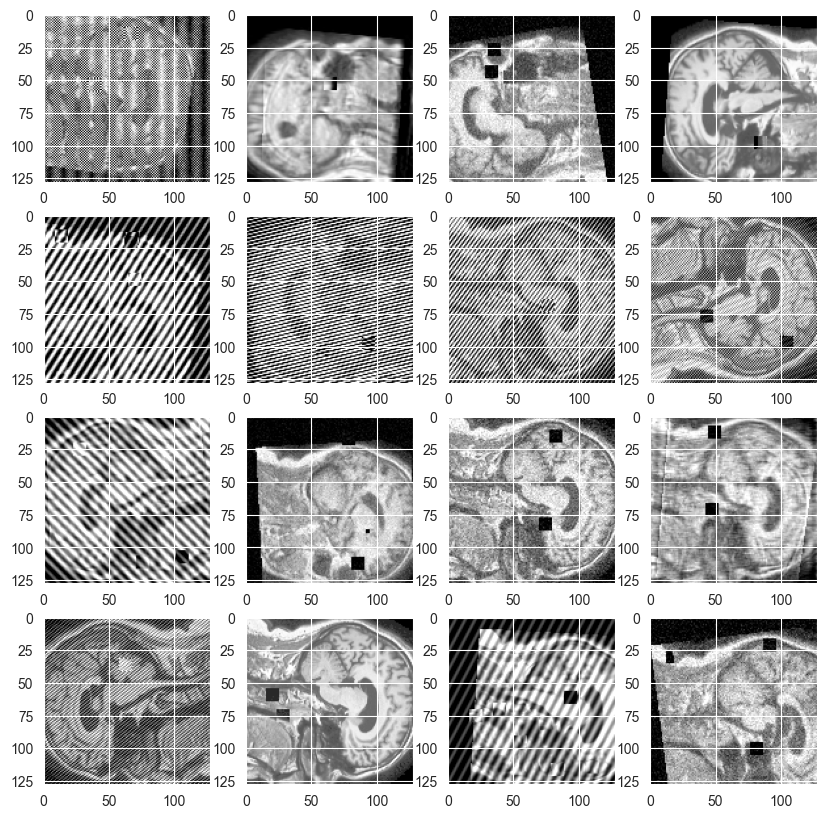

In [19]:
plt.figure(figsize=(10,10))
for i in range(16):
    image = equalize_hist(rescale_intensity(dataset[5]["T1"].numpy())) / 255
    image = augmentations(image)
    plt.subplot(4, 4, i+1)
    plt.imshow(image[0, 60, :, :], cmap="gray")

In [20]:
dataset_train, dataset_val = torch.utils.data.random_split(dataset, [0.9, 0.1])

In [21]:
demographic_data = pd.read_excel(r"/Users/michaelhase/Desktop/train/IXI.xls")  # download this file from https://brain-development.org/ixi-dataset/

In [22]:
demographic_data = demographic_data[["IXI_ID", "SEX_ID (1=m, 2=f)", "AGE"]].dropna()

In [23]:
def get_ground_truth(subject_id: str) -> tuple[int, float]:
    subject_number = int(subject_id.split("-")[0].replace("IXI", ""))
    row = demographic_data[demographic_data["IXI_ID"] == subject_number]
    return row["SEX_ID (1=m, 2=f)"].values[0] - 1, row["AGE"].values[0]

In [24]:
model = MRINet(num_classes=2, pretrain=True).to("mps")

In [25]:
batch_size = 10
num_epochs = 30

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion_ce = torch.nn.BCEWithLogitsLoss()
criterion_mse = torch.nn.MSELoss()
save_best = SaveBestModelLoss(save_path="models/pretrained")
history = {
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(num_epochs):
    train_acc, train_mse, val_mse, running_loss, val_running_loss = 0.0, 0.0, 0.0, 0.0, 0.0
    prbar = tqdm(torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, drop_last=True), leave=True)
    model.train()
    i = 1
    for batch in prbar:
        try:
            labels = torch.tensor([get_ground_truth(subject_id) for subject_id in batch["subject_id"]]).float()
        except IndexError:
            continue
        inputs = batch["T1"][torchio.DATA].float()
        inputs = normalize_batched(inputs)
        inputs = augment_batched(inputs)
        optimizer.zero_grad()
        output_0, output_1 = model(inputs.to("mps"))
        output_0 = output_0.squeeze()
        output_1 = output_1.squeeze()
        ce = criterion_ce(output_0.to("mps"), labels[:, 0])
        mse = criterion_mse(output_1.to("mps"), labels[:, 1])
        loss = ce + mse
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_mse += mse.item()
        prbar.set_description(
                f"Epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                f"Step MSE: {round(mse.item() / batch_size, 3)}, "
                f"Train MSE: {round(train_mse / (i * batch_size), 3)}, "
                f"Running Loss: {round(running_loss / i, 3)}")
        i += 1
    history["train_loss"].append(running_loss / i)
    model.eval()
    with torch.no_grad():

        i = 1
        prbar = tqdm(torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, drop_last=True), leave=True)
        for batch in prbar:
            try:
                labels = torch.tensor([get_ground_truth(subject_id) for subject_id in batch["subject_id"]])
            except IndexError:
                continue
            inputs = batch["T1"][torchio.DATA].float()
            inputs = normalize_batched(inputs)
            output_0, output_1 = model(inputs.to("mps"))
            output_0 = output_0.squeeze()
            output_1 = output_1.squeeze()
            ce = criterion_ce(output_0.to("mps"), labels[:, 0])
            mse = criterion_mse(output_1.to("mps"), labels[:, 1])
            val_mse += mse.item()
            loss = ce + mse
            val_running_loss += loss.item()
            prbar.set_description(
                            f"Epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                            f"Step MSE: {round(mse.item() / batch_size, 3)}, "
                            f"Valid MSE: {round(val_mse / (i * batch_size), 3)}, "
                            f"Running Loss: {round(val_running_loss / i, 3)}"
            )
            i += 1
        history["val_loss"].append(val_running_loss / i)
    save_best(val_running_loss, epoch, model)

  2%|▏         | 1/52 [00:04<04:10,  4.90s/it]


NotImplementedError: The operator 'aten::max_pool3d_with_indices' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
#plot history
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [ ]:
model = MRINet(num_classes=2, use_multiscale_stem=True, pretrain=True).to("mps")

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion_ce = torch.nn.BCEWithLogitsLoss()
criterion_mse = torch.nn.MSELoss()
save_best = SaveBestModelLoss(save_path="models/pretrained_multiscale")
history = {
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(num_epochs):
    train_acc, train_mse, val_mse, running_loss, val_running_loss = 0.0, 0.0, 0.0, 0.0, 0.0
    prbar = tqdm(torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, drop_last=True), leave=True)
    model.train()
    i = 1
    for batch in prbar:
        try:
            labels = torch.tensor([get_ground_truth(subject_id) for subject_id in batch["subject_id"]]).float()
        except IndexError:
            continue
        inputs = batch["T1"][torchio.DATA].float()
        inputs = normalize_batched(inputs)
        inputs = augment_batched(inputs)
        optimizer.zero_grad()
        output_0, output_1 = model(inputs.to("mps"))
        output_0 = output_0.squeeze()
        output_1 = output_1.squeeze()
        ce = criterion_ce(output_0.to("mps"), labels[:, 0])
        mse = criterion_mse(output_1.to("mps"), labels[:, 1])
        loss = ce + mse
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_mse += mse.item()
        prbar.set_description(
                f"Epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                f"Step MSE: {round(mse.item() / batch_size, 3)}, "
                f"Train MSE: {round(train_mse / (i * batch_size), 3)}, "
                f"Running Loss: {round(running_loss / i, 3)}")
        i += 1
    history["train_loss"].append(running_loss / i)
    model.eval()
    with torch.no_grad():

        i = 1
        prbar = tqdm(torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, drop_last=True), leave=True)
        for batch in prbar:
            try:
                labels = torch.tensor([get_ground_truth(subject_id) for subject_id in batch["subject_id"]])
            except IndexError:
                continue
            inputs = batch["T1"][torchio.DATA].float()
            inputs = normalize_batched(inputs)
            output_0, output_1 = model(inputs.to("mps"))
            output_0 = output_0.squeeze()
            output_1 = output_1.squeeze()
            ce = criterion_ce(output_0.to("mps"), labels[:, 0])
            mse = criterion_mse(output_1.to("mps"), labels[:, 1])
            val_mse += mse.item()
            loss = ce + mse
            val_running_loss += loss.item()
            prbar.set_description(
                            f"Epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                            f"Step MSE: {round(mse.item() / batch_size, 3)}, "
                            f"Valid MSE: {round(val_mse / (i * batch_size), 3)}, "
                            f"Running Loss: {round(val_running_loss / i, 3)}"
            )
            i += 1
        history["val_loss"].append(val_running_loss / i)
    save_best(val_running_loss, epoch, model)

In [ ]:
#plot history
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="validation loss")
plt.legend()
plt.show()